In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
with open('/content/gdrive/MyDrive/Colab Notebooks/advs.txt', encoding="utf8") as f:
    corpus = f.read().replace('\n',' ')

##Preprocessing

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


#Convert words to lowercase
corpus = corpus.lower()

#Tokenization
words = word_tokenize(corpus)

#Remove StopWords
table = str.maketrans('', '', string.punctuation)
words_stopwords_removed = [word.translate(table) for word in words]

#Remove Punctuations
stop_words = set(stopwords.words('english'))
words = [word for word in words_stopwords_removed if word not in stop_words and word != ""]

vocabulary = set(words)
word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for word, i in word_to_index.items()}


##Part1

In [107]:
# Parameters
embedding_size = 100
n_negative_samples = 4
window_size = 2

In [435]:
# Embedding and Context Matrix
import numpy as np
vocab_size = len(vocabulary)

W_embedding = np.random.randn(vocab_size, embedding_size)
W_context = np.random.randn(vocab_size, embedding_size)

In [109]:
# Negative Sampling Distribution
from collections import Counter
word_frequencies = Counter(words)
total_word_count = sum(word_frequencies.values())
word_frequencies = {word: count/total_word_count for word, count in word_frequencies.items()}

negative_sampling_distribution = np.array(list(word_frequencies.values()))**0.75
negative_sampling_distribution /= negative_sampling_distribution.sum()

In [110]:
# Negative Sample Generator Function
def generate_negative_samples(target_index, num_negative_samples):
    negative_samples = []
    while len(negative_samples) < num_negative_samples:
        sampled_index = np.random.choice(np.arange(vocab_size), p=negative_sampling_distribution)
        if sampled_index != target_index:
            negative_samples.append(sampled_index)
    return negative_samples

In [111]:
#Generate Samples
positive_pairs = []
for i, word in enumerate(words):
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        for j in range(start, end):
            if i != j and words[j] in word_to_index:
                positive_pairs.append((word_to_index[word], word_to_index[words[j]]))

In [112]:
#Generate Positive and Negative Samples
training_data = []
for target, context in positive_pairs:
    negative_samples = generate_negative_samples(target_index=target, num_negative_samples= n_negative_samples)

    training_sample = (target, context, 1)  #target 1 for positive
    training_data.append(training_sample)

    for neg_sample in negative_samples:
        training_data.append((target, neg_sample, 0))  #target 0 for negative

In [414]:
# Train
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

learning_rate = 0.01
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for target, context, label in training_data:
        v_target = W_embedding[target]
        v_context = W_context[context]
        score = np.dot(v_target, v_context)
        predicted_label = sigmoid(score)

        predicted_label = np.clip(predicted_label, 1e-15, 1 - 1e-15)

        g = predicted_label - label

        v_target_update = g * v_context
        v_context_update = g * v_target

        W_embedding[target] -= learning_rate * v_target_update
        W_context[context] -= learning_rate * v_context_update

        loss = -((label * np.log(predicted_label)) + ((1 - label) * np.log(1 - predicted_label)))
        total_loss += loss

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(training_data)}")

word_vectors = W_embedding + W_context

Epoch 1/5, Loss: 0.12028570774344614
Epoch 2/5, Loss: 0.07202677788747258
Epoch 3/5, Loss: 0.05523780246915267
Epoch 4/5, Loss: 0.04850004454950949
Epoch 5/5, Loss: 0.04604487443189084


In [436]:
word_vectors = W_embedding + W_context

In [438]:
def similarity(vec_a, vec_b):
    cosine_sim = np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
    return cosine_sim

king_vector = word_vectors[word_to_index.get('brother')]
man_vector = word_vectors[word_to_index.get('man')]
woman_vector = word_vectors[word_to_index.get('woman')]

word1 = word_vectors[word_to_index.get('sister')]

word2 = king_vector - man_vector + woman_vector

similarity(word1, word2)

0.41458908

In [437]:
word_vectors = W_embedding + W_context
word1 = word_vectors[word_to_index.get('sherlock')]
word2 = word_vectors[word_to_index.get('holmes')]

similarity(word1, word2)

0.52386594

##Part3:

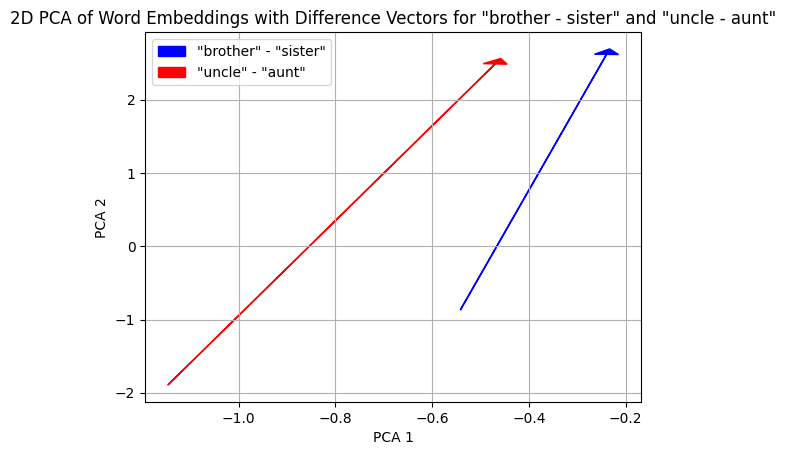

In [392]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
word_vectors_reduced = pca.fit_transform(word_vectors)

import matplotlib.pyplot as plt
# "brother" - "sister" difference vector
brother_vec = word_vectors_reduced[word_to_index['brother']]
sister_vec = word_vectors_reduced[word_to_index['sister']]
diff_vec_brother_sister = brother_vec - sister_vec
plt.arrow(sister_vec[0], sister_vec[1], diff_vec_brother_sister[0], diff_vec_brother_sister[1],
          head_width=0.05, fc='blue', ec='blue', label='"brother" - "sister"')

# "uncle" - "aunt" difference vector
uncle_vec = word_vectors_reduced[word_to_index['uncle']]
aunt_vec = word_vectors_reduced[word_to_index['aunt']]
diff_vec_uncle_aunt = uncle_vec - aunt_vec
plt.arrow(aunt_vec[0], aunt_vec[1], diff_vec_uncle_aunt[0], diff_vec_uncle_aunt[1],
          head_width=0.05, fc='red', ec='red', label='"uncle" - "aunt"')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA of Word Embeddings with Difference Vectors for "brother - sister" and "uncle - aunt"')
plt.legend()
plt.grid(True)
plt.show()